In [1]:
import time
import os

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import random
%matplotlib inline

In [3]:
import torch
import torchvision
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
from torchvision.datasets import ImageFolder
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import Tensor
import torchvision.models as models
from torchvision.models.resnet import ResNet

In [4]:
from functools import partial
from typing import Type, Any, Callable, Union, List, Optional
from types import FunctionType

In [5]:
# Seed
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [6]:
device = torch.device("cudap:0" if torch.cuda.is_available() else "cpu")

## Load datasets

In [7]:
train_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

In [8]:
train_dataset = ImageFolder('C:/Users/Aleksei_Bolshukhin/Desktop/computer_vision/2/imagewoof2/data/train',
                      transform = train_transforms)
test_dataset = ImageFolder('C:/Users/Aleksei_Bolshukhin/Desktop/computer_vision/2/imagewoof2/data/val',
                      transform = test_transforms)

(-0.5, 1125.5, 900.5, -0.5)

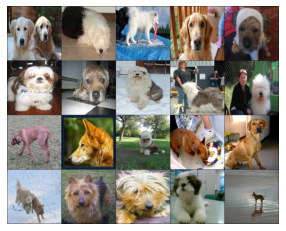

In [9]:
#Generating data loaders from the corresponding datasets
batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, num_workers=4)
  
#Plotting 20 images from the 1st batch 
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
plt.imshow(np.transpose(torchvision.utils.make_grid(
  images[:20], normalize=True, padding=1, nrow=5).numpy(), (1, 2, 0)))
plt.axis('off')

In [10]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
class_names = train_dataset.classes
number_of_classes = len(class_names)
print('Class names:', class_names)
print('Number of classes:', number_of_classes)

Train dataset size: 9025
Test dataset size: 3929
Class names: ['Australian_terrier', 'Beagle', 'Border_terrier', 'Dingo', 'English_foxhound', 'Golden_retriever', 'Old_English_sheepdog', 'Rhodesian_ridgeback', 'Samoyed', 'Shih-Tzu']
Number of classes: 10


# Train and compare some models

In [11]:
train_acc_dict = {}
test_acc_dict = {}

## BASELINE - experiment without pretrained weights

In [12]:
model_name = 'baseline'
train_acc_dict[model_name]=[]
test_acc_dict[model_name]=[]

In [13]:
from torchvision.models.resnet import ResNet, BasicBlock
class MyResNet18(ResNet):
    def __init__(self):
        super(MyResNet18, self).__init__(BasicBlock, [2, 2, 2, 2])


model = MyResNet18()


num_features = model.fc.in_features 
model.fc = nn.Linear(num_features, number_of_classes)
model = model.to(device)

num_epochs=20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.012148063188672934, momentum=0.9)

In [14]:
def training_model(model, num_epochs, optimizer, criterion, train_dataloader, test_dataloader):
    start_time = time.time()
    train_acc_list = []
    test_acc_list = []
    for epoch in range(num_epochs):
        print("Epoch {} running".format(epoch))
        model.train()
        running_loss = 0.
        running_corrects = 0 
        # load a batch data of images
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device) 
            # forward inputs and get output
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            # get loss value and update the network weights
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects / len(train_dataset) * 100.
        train_acc_list.append(epoch_acc.item())
        print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))
    

        model.eval()
        with torch.no_grad():
            running_loss = 0.
            running_corrects = 0
            for inputs, labels in test_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(test_dataset)
            epoch_acc = running_corrects / len(test_dataset) * 100.
            test_acc_list.append(epoch_acc.item())
            print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time()- start_time))
        
    return train_acc_list, test_acc_list      

In [15]:
train_acc_dict[model_name], test_acc_dict[model_name] = training_model(model, num_epochs, optimizer, criterion, train_dataloader, test_dataloader)

Epoch 0 running
[Train #0] Loss: 2.2023 Acc: 17.8504% Time: 571.9946s
[Test #0] Loss: 2.4708 Acc: 17.3327% Time: 697.3810s
Epoch 1 running
[Train #1] Loss: 1.9266 Acc: 29.0637% Time: 1280.2619s
[Test #1] Loss: 2.1795 Acc: 23.7974% Time: 1404.0032s
Epoch 2 running
[Train #2] Loss: 1.7039 Acc: 38.5042% Time: 1986.5448s
[Test #2] Loss: 4.0233 Acc: 20.4887% Time: 2108.4771s
Epoch 3 running
[Train #3] Loss: 1.5664 Acc: 43.6787% Time: 2691.9908s
[Test #3] Loss: 2.1717 Acc: 28.7859% Time: 2813.8462s
Epoch 4 running
[Train #4] Loss: 1.3675 Acc: 51.2687% Time: 3397.4222s
[Test #4] Loss: 3.3097 Acc: 26.8262% Time: 3519.3077s
Epoch 5 running
[Train #5] Loss: 1.1571 Acc: 58.6371% Time: 4101.6092s
[Test #5] Loss: 2.4383 Acc: 28.6078% Time: 4223.8759s
Epoch 6 running
[Train #6] Loss: 0.9176 Acc: 67.5789% Time: 4807.7494s
[Test #6] Loss: 2.3085 Acc: 35.3780% Time: 4930.4272s
Epoch 7 running
[Train #7] Loss: 0.6511 Acc: 77.5069% Time: 5515.9449s
[Test #7] Loss: 3.1341 Acc: 32.0183% Time: 5637.0985s
Ep

In [15]:
train_acc_dict[model_name], test_acc_dict[model_name] = training_model(model, num_epochs, optimizer, criterion, train_dataloader, test_dataloader)

Epoch 0 running
[Train #0] Loss: 2.1870 Acc: 18.2161% Time: 581.7882s
[Test #0] Loss: 2.1559 Acc: 22.1176% Time: 721.9104s
Epoch 1 running
[Train #1] Loss: 1.9167 Acc: 29.2299% Time: 1327.9012s
[Test #1] Loss: 2.3398 Acc: 19.1143% Time: 1461.9735s
Epoch 2 running
[Train #2] Loss: 1.7116 Acc: 37.9723% Time: 2068.5313s
[Test #2] Loss: 3.2144 Acc: 24.9682% Time: 2204.8539s
Epoch 3 running
[Train #3] Loss: 1.5793 Acc: 43.7452% Time: 2809.9421s
[Test #3] Loss: 1.9896 Acc: 35.1234% Time: 2945.9283s
Epoch 4 running
[Train #4] Loss: 1.3860 Acc: 50.3269% Time: 3552.8814s
[Test #4] Loss: 2.1187 Acc: 28.9387% Time: 3688.0814s
Epoch 5 running
[Train #5] Loss: 1.2344 Acc: 56.1884% Time: 4291.6990s
[Test #5] Loss: 2.3002 Acc: 32.7055% Time: 4425.4240s
Epoch 6 running
[Train #6] Loss: 0.9752 Acc: 66.0609% Time: 5033.7855s
[Test #6] Loss: 4.1617 Acc: 28.2769% Time: 5167.9307s
Epoch 7 running
[Train #7] Loss: 0.7624 Acc: 73.7729% Time: 5775.9769s
[Test #7] Loss: 3.3210 Acc: 31.2548% Time: 5910.0523s
Ep

In [16]:
train_acc_dict[model_name]

[18.216066360473633,
 29.229917526245117,
 37.97229766845703,
 43.74515151977539,
 50.326873779296875,
 56.18836212158203,
 66.06094360351562,
 73.7728500366211,
 81.52908325195312,
 89.67313385009766,
 92.43213653564453,
 96.35456848144531,
 98.50415802001953,
 99.51246643066406,
 99.9113540649414,
 99.97783660888672,
 99.96675872802734,
 99.97783660888672,
 99.98892211914062,
 99.98892211914062]

In [17]:
test_acc_dict[model_name]

[22.117586135864258,
 19.11427879333496,
 24.968185424804688,
 35.12343978881836,
 28.93865966796875,
 32.70552062988281,
 28.276914596557617,
 31.254772186279297,
 30.822092056274414,
 33.672691345214844,
 33.494529724121094,
 41.20641326904297,
 44.362430572509766,
 46.16950607299805,
 47.84932327270508,
 51.41257095336914,
 50.241790771484375,
 52.50699996948242,
 53.06694030761719,
 52.50699996948242]

Text(0, 0.5, 'Accuracy')

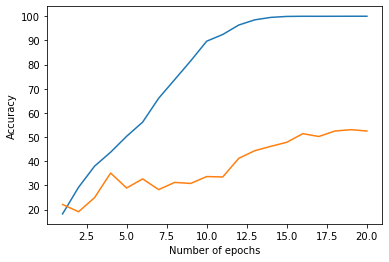

In [18]:
plt.plot(range(1,num_epochs+1), train_acc_dict[model_name])
plt.plot(range(1,num_epochs+1), test_acc_dict[model_name])
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")

In [19]:
torch.save(model.state_dict(), model_name + '.pth')

## Experiment with linearwarpup_cosine

In [13]:
model_name = 'linearwarpup_cosine'
train_acc_dict[model_name]=[]
test_acc_dict[model_name]=[]

In [14]:
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmupRestarts(_LRScheduler):
    """
        optimizer (Optimizer): Wrapped optimizer.
        first_cycle_steps (int): First cycle step size.
        cycle_mult(float): Cycle steps magnification. Default: -1.
        max_lr(float): First cycle's max learning rate. Default: 0.1.
        min_lr(float): Min learning rate. Default: 0.001.
        warmup_steps(int): Linear warmup step size. Default: 0.
        gamma(float): Decrease rate of max learning rate by cycle. Default: 1.
        last_epoch (int): The index of last epoch. Default: -1.
    """
    
    def __init__(self,
                 optimizer : torch.optim.Optimizer,
                 first_cycle_steps : int,
                 cycle_mult : float = 1.,
                 max_lr : float = 0.1,
                 min_lr : float = 0.001,
                 warmup_steps : int = 0,
                 gamma : float = 1.,
                 last_epoch : int = -1
        ):
        assert warmup_steps < first_cycle_steps
        
        self.first_cycle_steps = first_cycle_steps # first cycle step size
        self.cycle_mult = cycle_mult # cycle steps magnification
        self.base_max_lr = max_lr # first max learning rate
        self.max_lr = max_lr # max learning rate in the current cycle
        self.min_lr = min_lr # min learning rate
        self.warmup_steps = warmup_steps # warmup step size
        self.gamma = gamma # decrease rate of max learning rate by cycle
        
        self.cur_cycle_steps = first_cycle_steps # first cycle step size
        self.cycle = 0 # cycle count
        self.step_in_cycle = last_epoch # step size of the current cycle
        
        super(CosineAnnealingWarmupRestarts, self).__init__(optimizer, last_epoch)
        
        # set learning rate min_lr
        self.init_lr()
    
    def init_lr(self):
        self.base_lrs = []
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.min_lr
            self.base_lrs.append(self.min_lr)
    
    def get_lr(self):
        if self.step_in_cycle == -1:
            return self.base_lrs
        elif self.step_in_cycle < self.warmup_steps:
            return [(self.max_lr - base_lr)*self.step_in_cycle / self.warmup_steps + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.max_lr - base_lr) \
                    * (1 + math.cos(math.pi * (self.step_in_cycle-self.warmup_steps) \
                                    / (self.cur_cycle_steps - self.warmup_steps))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.step_in_cycle = self.step_in_cycle + 1
            if self.step_in_cycle >= self.cur_cycle_steps:
                self.cycle += 1
                self.step_in_cycle = self.step_in_cycle - self.cur_cycle_steps
                self.cur_cycle_steps = int((self.cur_cycle_steps - self.warmup_steps) * self.cycle_mult) + self.warmup_steps
        else:
            if epoch >= self.first_cycle_steps:
                if self.cycle_mult == 1.:
                    self.step_in_cycle = epoch % self.first_cycle_steps
                    self.cycle = epoch // self.first_cycle_steps
                else:
                    n = int(math.log((epoch / self.first_cycle_steps * (self.cycle_mult - 1) + 1), self.cycle_mult))
                    self.cycle = n
                    self.step_in_cycle = epoch - int(self.first_cycle_steps * (self.cycle_mult ** n - 1) / (self.cycle_mult - 1))
                    self.cur_cycle_steps = self.first_cycle_steps * self.cycle_mult ** (n)
            else:
                self.cur_cycle_steps = self.first_cycle_steps
                self.step_in_cycle = epoch
                
        self.max_lr = self.base_max_lr * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [15]:
from torchvision.models.resnet import ResNet, BasicBlock
class MyResNet18(ResNet):
    def __init__(self):
        super(MyResNet18, self).__init__(BasicBlock, [2, 2, 2, 2])


model = MyResNet18()


num_features = model.fc.in_features 
model.fc = nn.Linear(num_features, number_of_classes)
model = model.to(device)

lr_list = []
num_epochs=20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler=CosineAnnealingWarmupRestarts(optimizer,
                                          first_cycle_steps=20,
                                          cycle_mult=1.0,
                                          max_lr=0.025,
                                          min_lr=0.0075,
                                          warmup_steps=4,
                                          gamma=1.0)

In [16]:
def training_model(model, num_epochs, optimizer, criterion, scheduler, train_dataloader, test_dataloader):
    start_time = time.time()
    train_acc_list = []
    test_acc_list = []
    for epoch in range(num_epochs):
        print("Epoch {} running".format(epoch))
        model.train()
        running_loss = 0.
        running_corrects = 0 
        # load a batch data of images
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device) 
            # forward inputs and get output
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            # get loss value and update the network weights
            loss.backward()
            optimizer.step()
            #print(optimizer.state_dict()["param_groups"][0]["lr"])
            lr_list.append(optimizer.state_dict()["param_groups"][0]["lr"])
            scheduler.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        # scheduler.step()
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects / len(train_dataset) * 100.
        train_acc_list.append(epoch_acc.item())
        print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))
    

        model.eval()
        with torch.no_grad():
            running_loss = 0.
            running_corrects = 0
            for inputs, labels in test_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(test_dataset)
            epoch_acc = running_corrects / len(test_dataset) * 100.
            test_acc_list.append(epoch_acc.item())
            print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time()- start_time))
        
    return train_acc_list, test_acc_list      

In [16]:
train_acc_dict[model_name], test_acc_dict[model_name]  = training_model(model, num_epochs, optimizer, criterion, scheduler, train_dataloader, test_dataloader)

Epoch 0 running
[Train #0] Loss: 2.2633 Acc: 17.7064% Time: 595.5403s
[Test #0] Loss: 2.7194 Acc: 20.2342% Time: 810.6955s
Epoch 1 running
[Train #1] Loss: 1.9456 Acc: 28.5983% Time: 1854.2837s
[Test #1] Loss: 2.0816 Acc: 28.6332% Time: 1979.2070s
Epoch 2 running
[Train #2] Loss: 1.7213 Acc: 37.6842% Time: 2576.3721s
[Test #2] Loss: 2.7283 Acc: 26.1390% Time: 2701.3486s
Epoch 3 running
[Train #3] Loss: 1.5782 Acc: 43.5679% Time: 3303.6307s
[Test #3] Loss: 2.0999 Acc: 25.8335% Time: 3436.0073s
Epoch 4 running
[Train #4] Loss: 1.4056 Acc: 50.1385% Time: 4036.8061s
[Test #4] Loss: 1.9834 Acc: 38.2795% Time: 4159.1483s
Epoch 5 running
[Train #5] Loss: 1.2099 Acc: 57.1191% Time: 4760.6794s
[Test #5] Loss: 2.6537 Acc: 26.5716% Time: 4883.6999s
Epoch 6 running
[Train #6] Loss: 0.9783 Acc: 64.7645% Time: 5488.2683s
[Test #6] Loss: 2.3355 Acc: 39.4757% Time: 5611.0168s
Epoch 7 running
[Train #7] Loss: 0.7472 Acc: 74.0609% Time: 6213.1658s
[Test #7] Loss: 9.2195 Acc: 16.8236% Time: 6336.2896s
Ep

In [17]:
train_acc_dict[model_name]

[17.706371307373047,
 28.598339080810547,
 37.68421173095703,
 43.567867279052734,
 50.13850402832031,
 57.11911392211914,
 64.76454162597656,
 74.06094360351562,
 81.71745300292969,
 88.38780975341797,
 90.81440734863281,
 94.29363250732422,
 96.56509399414062,
 98.04985809326172,
 99.15789031982422,
 99.78947448730469,
 99.97783660888672,
 99.97783660888672,
 99.98892211914062,
 99.98892211914062]

In [18]:
test_acc_dict[model_name]

[20.234155654907227,
 28.63323974609375,
 26.138967514038086,
 25.83354377746582,
 38.27946090698242,
 26.571645736694336,
 39.47569274902344,
 16.823619842529297,
 29.142274856567383,
 23.873760223388672,
 37.92313766479492,
 35.301605224609375,
 45.20234298706055,
 41.76634979248047,
 40.26469802856445,
 46.32221984863281,
 52.83787155151367,
 53.27055358886719,
 53.95774841308594,
 54.13591384887695]

In [19]:
lr_list

[0.0075,
 0.011875,
 0.01625,
 0.020625,
 0.025,
 0.02483187120352827,
 0.02433394590947376,
 0.023525359107647272,
 0.02243718433538229,
 0.021111239538921522,
 0.01959848003319454,
 0.017957040317641122,
 0.01625,
 0.014542959682358879,
 0.012901519966805466,
 0.011388760461078482,
 0.010062815664617709,
 0.008974640892352729,
 0.008166054090526242,
 0.007668128796471734,
 0.0075,
 0.011875,
 0.01625,
 0.020625,
 0.025,
 0.02483187120352827,
 0.02433394590947376,
 0.023525359107647272,
 0.02243718433538229,
 0.021111239538921522,
 0.01959848003319454,
 0.017957040317641122,
 0.01625,
 0.014542959682358879,
 0.012901519966805466,
 0.011388760461078482,
 0.010062815664617709,
 0.008974640892352729,
 0.008166054090526242,
 0.007668128796471734,
 0.0075,
 0.011875,
 0.01625,
 0.020625,
 0.025,
 0.02483187120352827,
 0.02433394590947376,
 0.023525359107647272,
 0.02243718433538229,
 0.021111239538921522,
 0.01959848003319454,
 0.017957040317641122,
 0.01625,
 0.014542959682358879,
 0.0129

Text(0, 0.5, 'Accuracy')

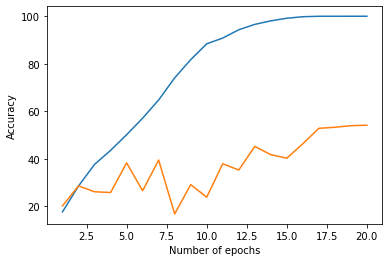

In [20]:
plt.plot(range(1,num_epochs+1), train_acc_dict[model_name])
plt.plot(range(1,num_epochs+1), test_acc_dict[model_name])
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")

In [21]:
torch.save(model.state_dict(), model_name + '.pth')

## Experiment - without BN

In [13]:
model_name = 'without_BN'
train_acc_dict[model_name]=[]
test_acc_dict[model_name]=[]

In [14]:
def _log_api_usage_once(obj: Any) -> None:

    """
    Logs API usage(module and name) within an organization.
    In a large ecosystem, it's often useful to track the PyTorch and
    TorchVision APIs usage. This API provides the similar functionality to the
    logging module in the Python stdlib. It can be used for debugging purpose
    to log which methods are used and by default it is inactive, unless the user
    manually subscribes a logger via the `SetAPIUsageLogger method <https://github.com/pytorch/pytorch/blob/eb3b9fe719b21fae13c7a7cf3253f970290a573e/c10/util/Logging.cpp#L114>`_.
    Please note it is triggered only once for the same API call within a process.
    It does not collect any data from open-source users since it is no-op by default.
    For more information, please refer to
    * PyTorch note: https://pytorch.org/docs/stable/notes/large_scale_deployments.html#api-usage-logging;
    * Logging policy: https://github.com/pytorch/vision/issues/5052;
    Args:
        obj (class instance or method): an object to extract info from.
    """
    module = obj.__module__
    if not module.startswith("torchvision"):
        module = f"torchvision.internal.{module}"
    name = obj.__class__.__name__
    if isinstance(obj, FunctionType):
        name = obj.__name__
    torch._C._log_api_usage_once(f"{module}.{name}")

In [15]:
from torchvision.models.resnet import ResNet, BasicBlock

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        #self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        #self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        #out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        #out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        #out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        #out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        #out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        #x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [16]:
class MyResNet18(ResNet):
    def __init__(self):
        super(MyResNet18, self).__init__(BasicBlock, [2, 2, 2, 2])


model = MyResNet18()
# if you need pretrained weights
#model.load_state_dict(models.resnet18(pretrained=True).state_dict())

num_epochs=20
num_features = model.fc.in_features 
model.fc = nn.Linear(num_features, number_of_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [17]:
def training_model(model, num_epochs, optimizer, criterion, train_dataloader, test_dataloader):
    start_time = time.time()
    train_acc_list = []
    test_acc_list = []
    for epoch in range(num_epochs):
        print("Epoch {} running".format(epoch))
        model.train()
        running_loss = 0.
        running_corrects = 0 
        # load a batch data of images
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device) 
            # forward inputs and get output
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            # get loss value and update the network weights
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects / len(train_dataset) * 100.
        train_acc_list.append(epoch_acc.item())
        print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))
    

        model.eval()
        with torch.no_grad():
            running_loss = 0.
            running_corrects = 0
            for inputs, labels in test_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(test_dataset)
            epoch_acc = running_corrects / len(test_dataset) * 100.
            test_acc_list.append(epoch_acc.item())
            print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time()- start_time))
        
    return train_acc_list, test_acc_list      

In [18]:
model

MyResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

In [19]:
train_acc_dict[model_name], test_acc_dict[model_name] = training_model(model, num_epochs, optimizer, criterion, train_dataloader, test_dataloader)

Epoch 0 running
[Train #0] Loss: 2.2348 Acc: 17.0637% Time: 557.1111s
[Test #0] Loss: 2.4929 Acc: 14.5584% Time: 676.5431s
Epoch 1 running
[Train #1] Loss: 2.0448 Acc: 23.5125% Time: 1240.9185s
[Test #1] Loss: 2.2734 Acc: 17.2818% Time: 1359.5810s
Epoch 2 running
[Train #2] Loss: 1.9559 Acc: 26.4709% Time: 1924.6989s
[Test #2] Loss: 2.8218 Acc: 16.7727% Time: 2044.1041s
Epoch 3 running
[Train #3] Loss: 1.8886 Acc: 29.4294% Time: 2611.5331s
[Test #3] Loss: 3.2875 Acc: 16.2891% Time: 2729.8593s
Epoch 4 running
[Train #4] Loss: 1.8141 Acc: 33.1745% Time: 3296.0772s
[Test #4] Loss: 2.2247 Acc: 21.8122% Time: 3414.0856s
Epoch 5 running
[Train #5] Loss: 1.7282 Acc: 36.3767% Time: 3979.0152s
[Test #5] Loss: 2.4097 Acc: 22.4230% Time: 4098.1163s
Epoch 6 running
[Train #6] Loss: 1.6336 Acc: 39.8560% Time: 4670.3244s
[Test #6] Loss: 2.1004 Acc: 21.5831% Time: 4787.0395s
Epoch 7 running
[Train #7] Loss: 1.5976 Acc: 41.9723% Time: 5344.2014s
[Test #7] Loss: 2.3009 Acc: 23.4920% Time: 5461.3800s
Ep

In [20]:
train_acc_dict[model_name]

[17.063711166381836,
 23.51246452331543,
 26.470914840698242,
 29.429363250732422,
 33.17451477050781,
 36.376731872558594,
 39.85595703125,
 41.9723014831543,
 45.51800537109375,
 46.18282699584961,
 48.89750671386719,
 53.18559265136719,
 55.556785583496094,
 58.31578826904297,
 61.47368621826172,
 63.09141540527344,
 68.64265441894531,
 69.1966781616211,
 73.93905639648438,
 79.57894897460938]

In [21]:
test_acc_dict[model_name]

[14.558412551879883,
 17.28175163269043,
 16.772716522216797,
 16.289133071899414,
 21.812166213989258,
 22.42300796508789,
 21.583099365234375,
 23.49198341369629,
 21.710357666015625,
 25.884449005126953,
 35.836090087890625,
 30.33850860595703,
 38.43217086791992,
 40.21379470825195,
 39.8829231262207,
 32.09468078613281,
 45.6350212097168,
 42.3262939453125,
 40.31560134887695,
 33.08729934692383]

Text(0, 0.5, 'Accuracy')

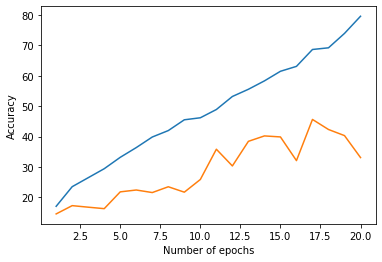

In [22]:
plt.plot(range(1,num_epochs+1), train_acc_dict[model_name])
plt.plot(range(1,num_epochs+1), test_acc_dict[model_name])
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")

In [23]:
torch.save(model.state_dict(), model_name + '.pth')

## Experiment - without Residual

In [13]:
model_name = 'without_Residual'
train_acc_dict[model_name]=[]
test_acc_dict[model_name]=[]

In [14]:
from torchvision.models.resnet import ResNet

In [15]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

In [16]:
class MyResNet18(ResNet):
    def __init__(self):
        super(MyResNet18, self).__init__(BasicBlock, [2, 2, 2, 2])


model = MyResNet18()
# if you need pretrained weights
#model.load_state_dict(models.resnet18(pretrained=True).state_dict())

num_epochs=20
num_features = model.fc.in_features 
model.fc = nn.Linear(num_features, number_of_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [19]:
def training_model(model, num_epochs, optimizer, criterion, train_dataloader, test_dataloader):
    start_time = time.time()
    train_acc_list = []
    test_acc_list = []
    for epoch in range(num_epochs):
        print("Epoch {} running".format(epoch))
        model.train()
        running_loss = 0.
        running_corrects = 0 
        # load a batch data of images
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device) 
            # forward inputs and get output
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            # get loss value and update the network weights
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects / len(train_dataset) * 100.
        train_acc_list.append(epoch_acc.item())
        print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))
    

        model.eval()
        with torch.no_grad():
            running_loss = 0.
            running_corrects = 0
            for inputs, labels in test_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(test_dataset)
            epoch_acc = running_corrects / len(test_dataset) * 100.
            test_acc_list.append(epoch_acc.item())
            print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time()- start_time))
        
    return train_acc_list, test_acc_list      

In [17]:
model

MyResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [20]:
train_acc_dict[model_name], test_acc_dict[model_name] = training_model(model, num_epochs, optimizer, criterion, train_dataloader, test_dataloader)

Epoch 0 running
[Train #0] Loss: 2.2490 Acc: 14.5374% Time: 618.6855s
[Test #0] Loss: 2.1609 Acc: 20.7177% Time: 739.5735s
Epoch 1 running
[Train #1] Loss: 1.9832 Acc: 25.8837% Time: 1357.8148s
[Test #1] Loss: 2.1482 Acc: 23.2120% Time: 1490.3848s
Epoch 2 running
[Train #2] Loss: 1.8467 Acc: 30.7368% Time: 2107.9384s
[Test #2] Loss: 2.4291 Acc: 23.9247% Time: 2244.6920s
Epoch 3 running
[Train #3] Loss: 1.7141 Acc: 36.1662% Time: 2862.5513s
[Test #3] Loss: 2.4155 Acc: 25.3500% Time: 2997.1382s
Epoch 4 running
[Train #4] Loss: 1.5682 Acc: 42.5263% Time: 3612.3692s
[Test #4] Loss: 2.0562 Acc: 28.6332% Time: 3746.0827s
Epoch 5 running
[Train #5] Loss: 1.4290 Acc: 48.6427% Time: 4365.1659s
[Test #5] Loss: 3.0524 Acc: 11.3515% Time: 4499.1796s
Epoch 6 running
[Train #6] Loss: 1.2944 Acc: 53.4626% Time: 5115.8500s
[Test #6] Loss: 2.1017 Acc: 25.0445% Time: 5249.3036s
Epoch 7 running
[Train #7] Loss: 1.1637 Acc: 58.5485% Time: 5865.7497s
[Test #7] Loss: 2.2201 Acc: 31.1530% Time: 6001.3790s
Ep

In [21]:
train_acc_dict[model_name]

[14.537395477294922,
 25.883657455444336,
 30.73684310913086,
 36.16620635986328,
 42.52631759643555,
 48.64265823364258,
 53.462608337402344,
 58.5484733581543,
 64.60942077636719,
 70.19390106201172,
 77.77285766601562,
 80.7313003540039,
 84.64266204833984,
 91.54570770263672,
 95.57894134521484,
 97.70637512207031,
 99.12464904785156,
 99.77839660644531,
 99.94459533691406,
 99.95568084716797]

In [22]:
test_acc_dict[model_name]

[20.71773910522461,
 23.212013244628906,
 23.92466163635254,
 25.34996223449707,
 28.63323974609375,
 11.351489067077637,
 25.044540405273438,
 31.15296745300293,
 33.29091262817383,
 35.657928466796875,
 23.313819885253906,
 35.352508544921875,
 42.60626220703125,
 40.2901496887207,
 40.8500862121582,
 44.46424102783203,
 42.75897216796875,
 48.612876892089844,
 49.07101058959961,
 52.02341842651367]

Text(0, 0.5, 'Accuracy')

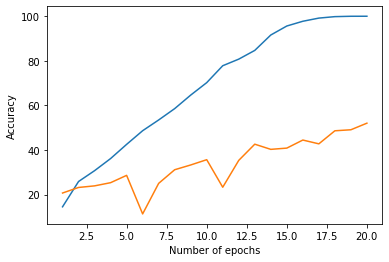

In [23]:
plt.plot(range(1,num_epochs+1), train_acc_dict[model_name])
plt.plot(range(1,num_epochs+1), test_acc_dict[model_name])
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")

In [24]:
torch.save(model.state_dict(), model_name + '.pth')

## Experiment - noise weights

In [12]:
model_name = 'noise_weights'
train_acc_dict[model_name]=[]
test_acc_dict[model_name]=[]

In [13]:
from torchvision.models.resnet import ResNet, BasicBlock
class MyResNet18(ResNet):
    def __init__(self):
        super(MyResNet18, self).__init__(BasicBlock, [2, 2, 2, 2])


model = MyResNet18()


num_features = model.fc.in_features 
model.fc = nn.Linear(num_features, number_of_classes)
model = model.to(device)

num_epochs=20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [14]:
model._modules['conv1'].weight.data.normal_()
model._modules['bn1'].weight.data.normal_()
model._modules['layer1'][0]._modules['conv1'].weight.data.normal_()
model._modules['layer1'][0]._modules['bn1'].weight.data.normal_()
model._modules['layer1'][0]._modules['conv2'].weight.data.normal_()
model._modules['layer1'][0]._modules['bn2'].weight.data.normal_()
model._modules['layer1'][1]._modules['conv1'].weight.data.normal_()
model._modules['layer1'][1]._modules['bn1'].weight.data.normal_()
model._modules['layer1'][1]._modules['conv2'].weight.data.normal_()
model._modules['layer1'][1]._modules['bn2'].weight.data.normal_()
model._modules['layer2'][0]._modules['conv1'].weight.data.normal_()
model._modules['layer2'][0]._modules['bn1'].weight.data.normal_()
model._modules['layer2'][0]._modules['conv2'].weight.data.normal_()
model._modules['layer2'][0]._modules['bn2'].weight.data.normal_()
model._modules['layer2'][1]._modules['conv1'].weight.data.normal_()
model._modules['layer2'][1]._modules['bn1'].weight.data.normal_()
model._modules['layer2'][1]._modules['conv2'].weight.data.normal_()
model._modules['layer1'][1]._modules['bn2'].weight.data.normal_()
model._modules['layer2'][0]._modules['downsample'][0].weight.data.normal_()
model._modules['layer2'][0]._modules['downsample'][1].weight.data.normal_()
model._modules['layer3'][0]._modules['conv1'].weight.data.normal_()
model._modules['layer3'][0]._modules['bn1'].weight.data.normal_()
model._modules['layer3'][0]._modules['conv2'].weight.data.normal_()
model._modules['layer3'][0]._modules['bn2'].weight.data.normal_()
model._modules['layer3'][1]._modules['conv1'].weight.data.normal_()
model._modules['layer3'][1]._modules['bn1'].weight.data.normal_()
model._modules['layer3'][1]._modules['conv2'].weight.data.normal_()
model._modules['layer3'][1]._modules['bn2'].weight.data.normal_()
model._modules['layer3'][0]._modules['downsample'][0].weight.data.normal_()
model._modules['layer3'][0]._modules['downsample'][1].weight.data.normal_()
model._modules['layer4'][0]._modules['conv1'].weight.data.normal_()
model._modules['layer4'][0]._modules['bn1'].weight.data.normal_()
model._modules['layer4'][0]._modules['conv2'].weight.data.normal_()
model._modules['layer4'][0]._modules['bn2'].weight.data.normal_()
model._modules['layer4'][1]._modules['conv1'].weight.data.normal_()
model._modules['layer4'][1]._modules['bn1'].weight.data.normal_()
model._modules['layer4'][1]._modules['conv2'].weight.data.normal_()
model._modules['layer4'][1]._modules['bn2'].weight.data.normal_()
model._modules['layer4'][0]._modules['downsample'][0].weight.data.normal_()
model._modules['layer4'][0]._modules['downsample'][1].weight.data.normal_()
model._modules['fc'].weight.data.normal_()

tensor([[-0.4189, -0.1505,  0.1587,  ..., -0.5710, -1.0611,  1.9420],
        [-0.0651, -0.3580, -1.0370,  ...,  0.4785, -0.0205, -0.8244],
        [ 1.0409, -1.0212, -1.3080,  ...,  1.0471,  0.4290,  2.4613],
        ...,
        [ 1.0205,  1.2396, -0.6003,  ...,  0.8732, -1.6951,  1.5794],
        [-0.1041,  1.1640, -0.1243,  ..., -1.0715, -0.4047, -0.5412],
        [ 0.4840, -0.2357, -0.7495,  ...,  0.2569, -1.4522, -0.1381]])

In [15]:
def training_model(model, num_epochs, optimizer, criterion, train_dataloader, test_dataloader):
    start_time = time.time()
    train_acc_list = []
    test_acc_list = []
    for epoch in range(num_epochs):
        print("Epoch {} running".format(epoch))
        model.train()
        running_loss = 0.
        running_corrects = 0 
        # load a batch data of images
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device) 
            # forward inputs and get output
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            # get loss value and update the network weights
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects / len(train_dataset) * 100.
        train_acc_list.append(epoch_acc.item())
        print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))
    

        model.eval()
        with torch.no_grad():
            running_loss = 0.
            running_corrects = 0
            for inputs, labels in test_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(test_dataset)
            epoch_acc = running_corrects / len(test_dataset) * 100.
            test_acc_list.append(epoch_acc.item())
            print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time()- start_time))
        
    return train_acc_list, test_acc_list      

In [16]:
train_acc_dict[model_name], test_acc_dict[model_name] = training_model(model, num_epochs, optimizer, criterion, train_dataloader, test_dataloader)

Epoch 0 running
[Train #0] Loss: 6.9727 Acc: 13.9723% Time: 622.0639s
[Test #0] Loss: 4.7317 Acc: 14.9402% Time: 763.6600s
Epoch 1 running
[Train #1] Loss: 3.9566 Acc: 18.4820% Time: 1408.4656s
[Test #1] Loss: 4.7260 Acc: 15.6528% Time: 1552.3203s
Epoch 2 running
[Train #2] Loss: 3.3914 Acc: 21.0416% Time: 2197.9095s
[Test #2] Loss: 3.6683 Acc: 18.1726% Time: 2339.6750s
Epoch 3 running
[Train #3] Loss: 2.9873 Acc: 24.5651% Time: 2987.7731s
[Test #3] Loss: 3.3229 Acc: 19.9033% Time: 3128.0932s
Epoch 4 running
[Train #4] Loss: 2.6780 Acc: 27.1579% Time: 3776.2664s
[Test #4] Loss: 3.2629 Acc: 20.7941% Time: 3920.9039s
Epoch 5 running
[Train #5] Loss: 2.4403 Acc: 29.1524% Time: 4583.2081s
[Test #5] Loss: 3.1102 Acc: 20.8450% Time: 4729.3853s
Epoch 6 running
[Train #6] Loss: 2.2190 Acc: 33.4404% Time: 5389.9220s
[Test #6] Loss: 3.1250 Acc: 20.3360% Time: 5531.7223s
Epoch 7 running
[Train #7] Loss: 2.1322 Acc: 34.3047% Time: 6179.4136s
[Test #7] Loss: 2.9132 Acc: 22.9829% Time: 6322.6183s
Ep

In [17]:
train_acc_dict[model_name]

[13.972298622131348,
 18.48199462890625,
 21.04155158996582,
 24.56509780883789,
 27.157894134521484,
 29.152355194091797,
 33.44044494628906,
 34.30470657348633,
 37.36288070678711,
 39.52354431152344,
 41.58448791503906,
 44.0443229675293,
 46.06093978881836,
 47.37950134277344,
 48.675899505615234,
 50.326873779296875,
 52.44321060180664,
 54.614959716796875,
 56.17728805541992,
 58.12742233276367]

In [18]:
test_acc_dict[model_name] 

[14.94018840789795,
 15.652838706970215,
 18.172563552856445,
 19.903282165527344,
 20.794095993041992,
 20.844999313354492,
 20.33596420288086,
 22.982948303222656,
 22.779333114624023,
 21.303131103515625,
 22.524816513061523,
 22.42300796508789,
 23.899211883544922,
 23.950115203857422,
 24.051921844482422,
 23.339271545410156,
 23.084753036499023,
 24.917282104492188,
 23.059303283691406,
 22.855688095092773]

Text(0, 0.5, 'Accuracy')

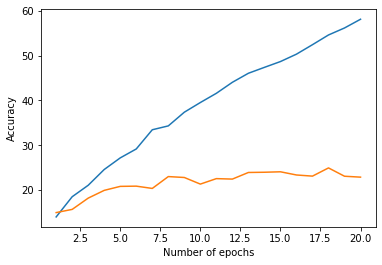

In [19]:
plt.plot(range(1,num_epochs+1), train_acc_dict[model_name])
plt.plot(range(1,num_epochs+1), test_acc_dict[model_name])
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")

In [20]:
torch.save(model.state_dict(), model_name + '.pth')

## Experiment with SiLU

In [12]:
model_name = 'SILU'
train_acc_dict[model_name]=[]
test_acc_dict[model_name]=[]

In [13]:
def _log_api_usage_once(obj: Any) -> None:

    """
    Logs API usage(module and name) within an organization.
    In a large ecosystem, it's often useful to track the PyTorch and
    TorchVision APIs usage. This API provides the similar functionality to the
    logging module in the Python stdlib. It can be used for debugging purpose
    to log which methods are used and by default it is inactive, unless the user
    manually subscribes a logger via the `SetAPIUsageLogger method <https://github.com/pytorch/pytorch/blob/eb3b9fe719b21fae13c7a7cf3253f970290a573e/c10/util/Logging.cpp#L114>`_.
    Please note it is triggered only once for the same API call within a process.
    It does not collect any data from open-source users since it is no-op by default.
    For more information, please refer to
    * PyTorch note: https://pytorch.org/docs/stable/notes/large_scale_deployments.html#api-usage-logging;
    * Logging policy: https://github.com/pytorch/vision/issues/5052;
    Args:
        obj (class instance or method): an object to extract info from.
    """
    module = obj.__module__
    if not module.startswith("torchvision"):
        module = f"torchvision.internal.{module}"
    name = obj.__class__.__name__
    if isinstance(obj, FunctionType):
        name = obj.__name__
    torch._C._log_api_usage_once(f"{module}.{name}")

In [14]:
from torchvision.models.resnet import ResNet, BasicBlock

In [15]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.SiLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.SiLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.SiLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [16]:
class MyResNet18(ResNet):
    def __init__(self):
        super(MyResNet18, self).__init__(BasicBlock, [2, 2, 2, 2])

In [17]:
model = MyResNet18()
# if you need pretrained weights
#model.load_state_dict(models.resnet18(pretrained=True).state_dict())

num_epochs=20
num_features = model.fc.in_features 
model.fc = nn.Linear(num_features, number_of_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.06999554872984425, momentum=0.9)

In [18]:
model

MyResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): SiLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): SiLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): SiLU(inplace=True

In [19]:
def training_model(model, num_epochs, optimizer, criterion, train_dataloader, test_dataloader):
    start_time = time.time()
    train_acc_list = []
    test_acc_list = []
    for epoch in range(num_epochs):
        print("Epoch {} running".format(epoch))
        model.train()
        running_loss = 0.
        running_corrects = 0 
        # load a batch data of images
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device) 
            # forward inputs and get output
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            # get loss value and update the network weights
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects / len(train_dataset) * 100.
        train_acc_list.append(epoch_acc)
        print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))
    

        model.eval()
        with torch.no_grad():
            running_loss = 0.
            running_corrects = 0
            for inputs, labels in test_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(test_dataset)
            epoch_acc = running_corrects / len(test_dataset) * 100.
            test_acc_list.append(epoch_acc)
            print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time()- start_time))
        
    return train_acc_list, test_acc_list      

In [20]:
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.handlers import ModelCheckpoint, FastaiLRFinder
from ignite.contrib.handlers import TensorboardLogger, global_step_from_engine

In [21]:
trainer = create_supervised_trainer(model, optimizer, criterion, device)

In [22]:
lr_finder = FastaiLRFinder()
to_save = {"model": model, "optimizer": optimizer}

with lr_finder.attach(trainer, to_save=to_save) as trainer_with_lr_finder:
    trainer_with_lr_finder.run(train_dataloader)

C:\ProgramData\Anaconda3\lib\site-packages\ignite\handlers\lr_finder.py:182: UserWarning: Run completed without loss diverging, increase end_lr, decrease diverge_th or look at lr_finder.plot()
  warnings.warn(


In [23]:
lr_finder.get_results()

{'lr': [0.011021825252050104,
  0.012148063188672934,
  0.013389382961641563,
  0.014757543923599039,
  0.016265507027536246,
  0.01792755760934974,
  0.019759440716631393,
  0.02177851026569549,
  0.024003893439847497,
  0.0264566718862831,
  0.029160081428143907,
  0.03213973218365538,
  0.03542385117759403,
  0.03904354974340706,
  0.04303311824915583,
  0.04743035093930039,
  0.05227690396963793,
  0.05761869002715537,
  0.06350631327313484,
  0.06999554872984425,
  0.07714787065217008,
  0.08503103488959832,
  0.09371972075541284,
  0.10329623848370932,
  0.1138513089761537,
  0.12548492322523297,
  0.1383072895555441,
  0.15243987765659014,
  0.1680165692974834,
  0.18518492662458286,
  0.20410759005698725,
  0.22496381902251933,
  0.24795119013000327,
  0.2732874688650746,
  0.30121267254059364,
  0.33199134404454134,
  0.36591505792521795,
  0.4033051825545542,
  0.44451592453624655,
  0.48993768419920003,
  0.5400007539637691,
  0.5951793946163965,
  0.6559963281082891,
  0.72

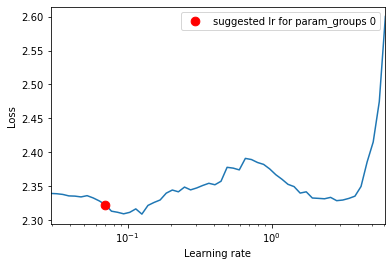

<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>

In [24]:
lr_finder.plot()

In [25]:
lr_finder.lr_suggestion()

0.06999554872984425

In [21]:
train_acc_dict[model_name], test_acc_dict[model_name] = training_model(model, num_epochs, optimizer, criterion, train_dataloader, test_dataloader)

Epoch 0 running
[Train #0] Loss: 2.1859 Acc: 18.9474% Time: 694.9462s
[Test #0] Loss: 2.5295 Acc: 15.5510% Time: 851.9963s
Epoch 1 running
[Train #1] Loss: 1.9089 Acc: 29.5180% Time: 1582.9767s
[Test #1] Loss: 2.0080 Acc: 30.5167% Time: 1731.6396s
Epoch 2 running
[Train #2] Loss: 1.7577 Acc: 36.4432% Time: 2463.8413s
[Test #2] Loss: 2.3831 Acc: 27.3097% Time: 2604.5127s
Epoch 3 running
[Train #3] Loss: 1.6318 Acc: 41.3518% Time: 3318.7164s
[Test #3] Loss: 1.7701 Acc: 37.0069% Time: 3463.1097s
Epoch 4 running
[Train #4] Loss: 1.4795 Acc: 46.6482% Time: 4289.3644s
[Test #4] Loss: 2.2505 Acc: 28.2515% Time: 4433.8209s
Epoch 5 running
[Train #5] Loss: 1.3514 Acc: 51.3684% Time: 5166.9131s
[Test #5] Loss: 3.5322 Acc: 22.6266% Time: 5310.7200s
Epoch 6 running
[Train #6] Loss: 1.1907 Acc: 56.9308% Time: 6035.0113s
[Test #6] Loss: 2.4785 Acc: 37.2868% Time: 6181.0075s
Epoch 7 running
[Train #7] Loss: 1.0166 Acc: 63.8116% Time: 6907.9630s
[Test #7] Loss: 2.0602 Acc: 33.3673% Time: 7048.4610s
Ep

In [20]:
train_acc_dict[model_name], test_acc_dict[model_name] = training_model(model, num_epochs, optimizer, criterion, train_dataloader, test_dataloader)

Epoch 0 running
[Train #0] Loss: 2.1859 Acc: 18.9474% Time: 663.4822s
[Test #0] Loss: 2.5295 Acc: 15.5510% Time: 810.6517s
Epoch 1 running
[Train #1] Loss: 1.9089 Acc: 29.5180% Time: 1475.1694s
[Test #1] Loss: 2.0080 Acc: 30.5167% Time: 1631.3897s
Epoch 2 running
[Train #2] Loss: 1.7577 Acc: 36.4432% Time: 2307.5916s
[Test #2] Loss: 2.3831 Acc: 27.3097% Time: 2457.7376s
Epoch 3 running
[Train #3] Loss: 1.6318 Acc: 41.3518% Time: 3104.2789s
[Test #3] Loss: 1.7701 Acc: 37.0069% Time: 3251.2221s
Epoch 4 running
[Train #4] Loss: 1.4795 Acc: 46.6482% Time: 3922.3260s
[Test #4] Loss: 2.2505 Acc: 28.2515% Time: 4067.6741s
Epoch 5 running
[Train #5] Loss: 1.3514 Acc: 51.3684% Time: 4741.9791s
[Test #5] Loss: 3.5322 Acc: 22.6266% Time: 4898.8607s
Epoch 6 running
[Train #6] Loss: 1.1907 Acc: 56.9308% Time: 5571.1696s
[Test #6] Loss: 2.4785 Acc: 37.2868% Time: 5719.3965s
Epoch 7 running
[Train #7] Loss: 1.0166 Acc: 63.8116% Time: 6366.7232s
[Test #7] Loss: 2.0602 Acc: 33.3673% Time: 6511.3068s
Ep

In [22]:
train_acc_dict[model_name]

[tensor(18.9474),
 tensor(29.5180),
 tensor(36.4432),
 tensor(41.3518),
 tensor(46.6482),
 tensor(51.3684),
 tensor(56.9308),
 tensor(63.8116),
 tensor(69.1191),
 tensor(77.9391),
 tensor(84.4654),
 tensor(89.9169),
 tensor(92.9861),
 tensor(94.6039),
 tensor(96.3656),
 tensor(97.8726),
 tensor(99.3352),
 tensor(99.5125),
 tensor(99.8670),
 tensor(99.9114)]

In [23]:
test_acc_dict[model_name]

[tensor(15.5510),
 tensor(30.5167),
 tensor(27.3097),
 tensor(37.0069),
 tensor(28.2515),
 tensor(22.6266),
 tensor(37.2868),
 tensor(33.3673),
 tensor(36.2433),
 tensor(38.6867),
 tensor(41.4355),
 tensor(41.1301),
 tensor(40.5447),
 tensor(45.1260),
 tensor(45.6859),
 tensor(51.6416),
 tensor(46.0932),
 tensor(55.7903),
 tensor(55.7139),
 tensor(57.0120)]

Text(0, 0.5, 'Accuracy')

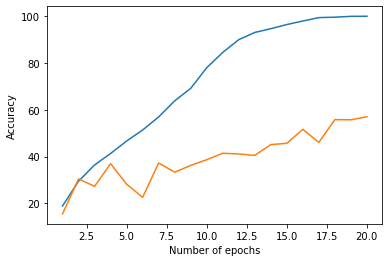

In [24]:
plt.plot(range(1,num_epochs+1), train_acc_dict[model_name])
plt.plot(range(1,num_epochs+1), test_acc_dict[model_name])
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")

In [25]:
torch.save(model.state_dict(), model_name + '.pth')

In [13]:
from torchvision.models.resnet import ResNet, BasicBlock
class MyResNet18(ResNet):
    def __init__(self):
        super(MyResNet18, self).__init__(BasicBlock, [2, 2, 2, 2])


model = MyResNet18()


num_features = model.fc.in_features 
model.fc = nn.Linear(num_features, number_of_classes)
model = model.to(device)

num_epochs=20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.43E-01


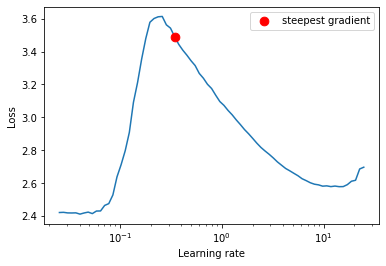

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 0.3430469286314917)

In [13]:
from torch_lr_finder import LRFinder

lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(train_dataloader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph

In [14]:
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.handlers import ModelCheckpoint, FastaiLRFinder
from ignite.contrib.handlers import TensorboardLogger, global_step_from_engine

In [15]:
trainer = create_supervised_trainer(model, optimizer, criterion, device)

In [16]:
lr_finder = FastaiLRFinder()
to_save = {"model": model, "optimizer": optimizer}

with lr_finder.attach(trainer, to_save=to_save) as trainer_with_lr_finder:
    trainer_with_lr_finder.run(train_dataloader)

C:\ProgramData\Anaconda3\lib\site-packages\ignite\handlers\lr_finder.py:182: UserWarning: Run completed without loss diverging, increase end_lr, decrease diverge_th or look at lr_finder.plot()
  warnings.warn(


In [19]:
lr_finder.get_results()

{'lr': [0.011021825252050104,
  0.012148063188672934,
  0.013389382961641563,
  0.014757543923599039,
  0.016265507027536246,
  0.01792755760934974,
  0.019759440716631393,
  0.02177851026569549,
  0.024003893439847497,
  0.0264566718862831,
  0.029160081428143907,
  0.03213973218365538,
  0.03542385117759403,
  0.03904354974340706,
  0.04303311824915583,
  0.04743035093930039,
  0.05227690396963793,
  0.05761869002715537,
  0.06350631327313484,
  0.06999554872984425,
  0.07714787065217008,
  0.08503103488959832,
  0.09371972075541284,
  0.10329623848370932,
  0.1138513089761537,
  0.12548492322523297,
  0.1383072895555441,
  0.15243987765659014,
  0.1680165692974834,
  0.18518492662458286,
  0.20410759005698725,
  0.22496381902251933,
  0.24795119013000327,
  0.2732874688650746,
  0.30121267254059364,
  0.33199134404454134,
  0.36591505792521795,
  0.4033051825545542,
  0.44451592453624655,
  0.48993768419920003,
  0.5400007539637691,
  0.5951793946163965,
  0.6559963281082891,
  0.72

C:\ProgramData\Anaconda3\lib\site-packages\ignite\handlers\lr_finder.py:275: UserWarning: skip_start is larger than the suggested LR found and it will not be visible on the plot. Please, make the value smaller.
  warnings.warn(


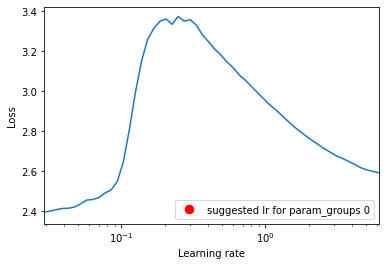

<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>

In [21]:
lr_finder.plot()

In [20]:
lr_finder.lr_suggestion()

0.012148063188672934

In [17]:
lr_finder.get_results()

{'lr': [0.0011385130897615372,
  0.0012962120555583619,
  0.001475754392359904,
  0.001680165692974834,
  0.0019128906344201126,
  0.0021778510265695493,
  0.002479511901300033,
  0.002822956755849604,
  0.003213973218365538,
  0.00365915057925218,
  0.004165990831887117,
  0.004743035093930039,
  0.005400007539637691,
  0.006147979268688503,
  0.006999554872984423,
  0.00796908484539692,
  0.009072907409904686,
  0.010329623848370932,
  0.011760411963683248,
  0.013389382961641567,
  0.015243987765659016,
  0.017355479611367516,
  0.0197594407166314,
  0.02249638190225193,
  0.02561242526798837,
  0.029160081428143914,
  0.033199134404454135,
  0.037797649088223625,
  0.04303311824915584,
  0.04899376841991999,
  0.05578004666282432,
  0.06350631327313486,
  0.07230276894396087,
  0.0823176488687034,
  0.09371972075541284,
  0.10670112884883351,
  0.1214806318867293,
  0.13830728955554406,
  0.1574646595684262,
  0.17927557609349745,
  0.2041075900569873,
  0.23237916299956177,
  0.26

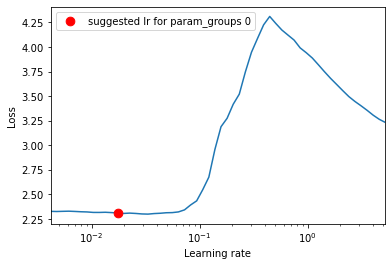

<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>

In [18]:
lr_finder.plot()

In [19]:
lr_finder.lr_suggestion()

0.017355479611367516